# Flop or Not? (Binary Classification)

# Setup

In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sb

%matplotlib inline
import matplotlib.pyplot as plt

from cleaning_tools import flatten, flatten_people, one_hot

# read in data
%store -r raw_data

# Cleaning
Zero make sense for `vote_average` and `vote_count`. Hence, we only need to check null values

In [3]:
raw_data[["vote_average", "vote_count"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vote_average  5000 non-null   float64
 1   vote_count    5000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


# Implement V-Score
Suppose a film has a `vote_average` = $a$ and `vote_count` = $n$. Then its $V$-score is given by:
$$
V \vcentcolon= \frac{\frac{a}{10}n + 1}{n + 2}
$$

We add a new column of $V$-scores to the dataframe. 

In [4]:
raw_data["v_score"] = ((raw_data["vote_average"]/10) * raw_data["vote_count"] + 1) / (raw_data["vote_count"] + 2)

Observe the distribution of $V$-scores. 

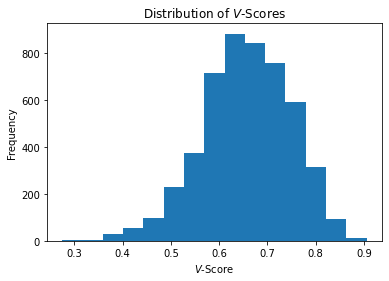

In [5]:
plt.figure(facecolor="white")

raw_data["v_score"].plot.hist(bins=15)

plt.title("Distribution of $V$-Scores")
plt.xlabel("$V$-Score")

plt.draw()
plt.show()

The distribution is slightly left skewed, which makes sense since the top $5000$ most popular movies are presumably well received. Keeping this in mind, let's use $65\%$ as the threshold for a flop (credit at Sydney Uni!).

In [6]:
raw_data["flop"] = raw_data["v_score"] < 0.65
raw_data[["flop"]].value_counts(sort=False)

flop 
False    2621
True     2379
dtype: int64

Visualise the split of flops to non-flops as well. 

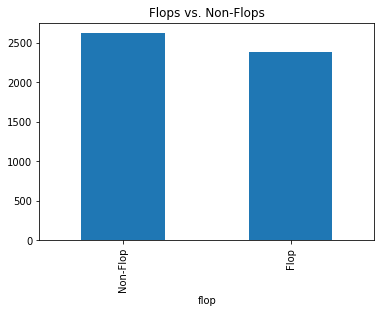

In [7]:
plt.figure(facecolor="white")

raw_data[["flop"]].value_counts(sort=False).plot.bar()

plt.title("Flops vs. Non-Flops")
plt.xticks(ticks=[0, 1], labels=["Non-Flop", "Flop"])

plt.draw()
plt.show()

# Data Preprocessing

## Released Films Only
We are only interested in released films. 

In [8]:
released_only = raw_data[raw_data["released"] == True]

## Zero Values

As we did in `exploratory.ipynb`, we should remove films with zero `budget`, `revenue`, or `runtime`. Notice that one major flaw to our data is that we are missing a lot of `budget` and `revenue` values. 

In [9]:
clean_budget = released_only[released_only["budget"] != 0]
clean_budget_and_revenue = clean_budget[clean_budget["revenue"] != 0]
data_zeroes_cleaned = clean_budget_and_revenue[clean_budget_and_revenue["runtime"] != 0]

data_zeroes_cleaned.shape


(2648, 26)

We lost over half of our observations, but there aren't really other alternatives. 

## Feature Scaling

It is good practice to ensure that all features are on the scale. In our dataset, `budget` and `revenue` will obviously be on a different scale to `runtime`. These are the only numerical features. 

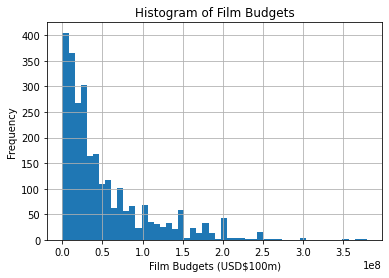

In [10]:
plt.figure(facecolor="white")

data_zeroes_cleaned["budget"].hist(bins=50)

plt.title("Histogram of Film Budgets")
plt.ylabel("Frequency")
plt.xlabel("Film Budgets (USD$100m)")

plt.draw()
plt.show()

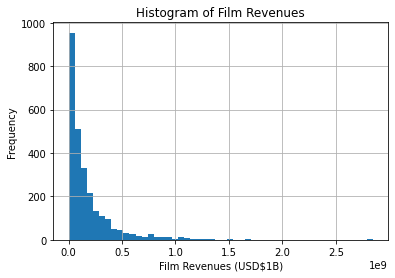

In [11]:
plt.figure(facecolor="white")

data_zeroes_cleaned["revenue"].hist(bins=50)

plt.title("Histogram of Film Revenues")
plt.ylabel("Frequency")
plt.xlabel("Film Revenues (USD$1B)")

plt.draw()
plt.show()

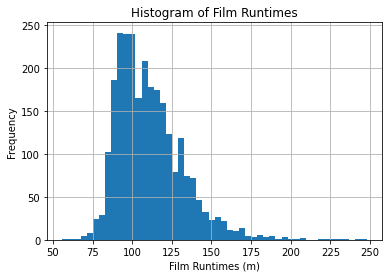

In [12]:
plt.figure(facecolor="white")

data_zeroes_cleaned["runtime"].hist(bins=50)

plt.title("Histogram of Film Runtimes")
plt.ylabel("Frequency")
plt.xlabel("Film Runtimes (m)")

plt.draw()
plt.show()


In [13]:
scaled_data = data_zeroes_cleaned

minmax_scaler = preprocessing.MinMaxScaler()

scaled_data[["budget", "revenue", "runtime"]] = minmax_scaler.fit_transform(data_zeroes_cleaned[["budget", "revenue", "runtime"]])

/var/folders/sg/rlk9vzs561n15bmvp6y81mxc0000gn/T/ipykernel_19113/1335140770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data[["budget", "revenue", "runtime"]] = minmax_scaler.fit_transform(data_zeroes_cleaned[["budget", "revenue", "runtime"]])


In [14]:
scaled_data[["budget", "revenue", "runtime"]].describe()

,budget,revenue,runtime
count,2648.000000,2648.000000,2648.000000
mean,0.134054,0.062589,0.286576
std,0.141252,0.086021,0.110751
min,0.000000,0.000000,0.000000
25%,0.034737,0.011792,0.208333
50%,0.078947,0.033342,0.265625
75%,0.184210,0.076820,0.343750
max,1.000000,1.000000,1.000000


## Dropping Obvious Features

Recall that there are $23$ columns (features) in total in the dataset. Some of these may be irrelevant, others may be too complicated for this task, and some should not be used. Hence, the first step we perform in feature selection is dropping the columns we obviously will not be using. These include:

- `imdb_id`: not relevant
- `popularity`: not useful, popularity can only be calculated after the fact
- `vote_count`, `vote_average`, `v_score`: used in definition of whether a film is a flop
- `release_date`, `released`: not useful, we are already working with released films only
- `overview`, `tagline`, `original_title`, `title`: too complicated, involves NLP, and can be proxied using `keywords`

We drop the above columns.

In [15]:
data_obv_dropped = scaled_data.drop(columns=["imdb_id", "popularity", "vote_count", "vote_average", "overview", "tagline", "original_title", "title", "v_score", "release_date", "released", "status"])
data_obv_dropped.head()

,adult,budget,genres,id,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,keywords,cast,crew,flop
0,False,0.526316,"[Action, Adventure, Science Fiction]",634649,en,"[Marvel Studios, Pascal Pictures, Columbia Pic...",[US],0.659123,0.479167,"[en, tl]","[new york city, hero, villain, comic book, seq...","[{'adult': False, 'gender': 2, 'id': 1136406, ...","[{'adult': False, 'gender': 1, 'id': 2519, 'kn...",False
1,False,0.486842,"[Crime, Mystery, Thriller]",414906,en,"[6th & Idaho, Dylan Clark Productions, DC Film...",[US],0.162690,0.625000,[en],"[dc comics, crime fighter, secret identity, vi...","[{'adult': False, 'gender': 2, 'id': 11288, 'k...","[{'adult': False, 'gender': 2, 'id': 2122, 'kn...",False
3,False,0.131579,"[Animation, Comedy, Family, Fantasy]",568124,en,"[Walt Disney Animation Studios, Walt Disney Pi...",[US],0.084291,0.239583,"[en, es]","[magic, musical, forest, family relationships,...","[{'adult': False, 'gender': 1, 'id': 968367, '...","[{'adult': False, 'gender': 0, 'id': 8159, 'kn...",False
6,False,0.263158,"[Action, Adventure, Thriller, War]",476669,en,"[Marv Films, Cloudy Productions, 20th Century ...","[GB, US]",0.043552,0.390625,[en],"[london, england, spy, world war i, based on c...","[{'adult': False, 'gender': 2, 'id': 5469, 'kn...","[{'adult': False, 'gender': 2, 'id': 497, 'kno...",False
8,False,0.063158,"[Horror, Mystery, Thriller]",646385,en,"[Paramount, Spyglass Entertainment, Project X ...",[US],0.048374,0.302083,[en],"[attempted murder, mask, hallucination, murder...","[{'adult': False, 'gender': 1, 'id': 9206, 'kn...","[{'adult': False, 'gender': 1, 'id': 409, 'kno...",False


### Too Many Missing Values


In [16]:
data_obv_dropped.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
keywords                0
cast                    0
crew                    0
flop                    0
dtype: int64

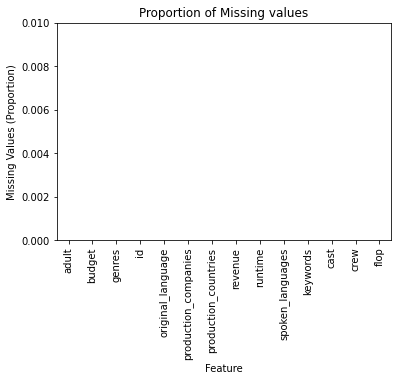

In [17]:
plt.figure(facecolor="white")

(data_obv_dropped.isna().sum() / data_obv_dropped.count()).plot.bar()

plt.title("Proportion of Missing values")
plt.ylabel("Missing Values (Proportion)")
plt.xlabel("Feature")

plt.ylim(0, 0.01)

plt.draw()
plt.show()

### Too Little Variance
Features that do not vary much are not very useful to prediction either. Clearly, this criterion applies only to the numerical columns. 

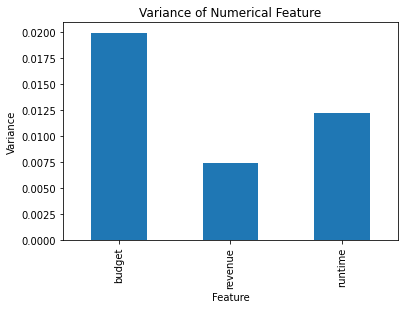

In [18]:
plt.figure(facecolor="white")

data_obv_dropped[["budget", "revenue", "runtime"]].var().plot.bar()

plt.title("Variance of Numerical Feature")
plt.ylabel("Variance")
plt.xlabel("Feature")

plt.draw()
plt.show()

We check for pairwise correlation between the numerical columns

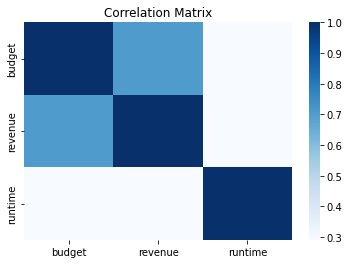

In [19]:
numerical_cols = ["budget", "revenue", "runtime"]

# # visualise
fig = plt.figure(facecolor="white")
sb.heatmap(data_obv_dropped[numerical_cols].corr(), cmap="Blues")

plt.title("Correlation Matrix")

plt.show()


## Feature Engineering

There are some features which need to be transformed or reshaped so that we can make predictions.

In [20]:
training_data = data_obv_dropped
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2648 entries, 0 to 4998
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 2648 non-null   bool   
 1   budget                2648 non-null   float64
 2   genres                2648 non-null   object 
 3   id                    2648 non-null   int64  
 4   original_language     2648 non-null   object 
 5   production_companies  2648 non-null   object 
 6   production_countries  2648 non-null   object 
 7   revenue               2648 non-null   float64
 8   runtime               2648 non-null   float64
 9   spoken_languages      2648 non-null   object 
 10  keywords              2648 non-null   object 
 11  cast                  2648 non-null   object 
 12  crew                  2648 non-null   object 
 13  flop                  2648 non-null   bool   
dtypes: bool(2), float64(3), int64(1), object(8)
memory usage: 274.1+ KB


### Binarisation
We need to convert boolean features (True, False) to binary (0, 1). The code is simple and built into `pandas`. The only boolean features are `adult` and `flop`. 

In [21]:
training_data[["adult", "flop"]] = training_data[["adult", "flop"]].replace({True: 1, False: 0})
training_data[["adult", "flop"]].value_counts()

adult  flop
0      0       1440
       1       1208
dtype: int64

### One Hot Encoding
Categorical features will need to be one hot encoded. We already wrote the code to one hot encode categorical features. The categorical features are `genres`, `original_language`, `production_companies`, `production_countries`, `spoken_languages`, and `keywords`. However, the large number of unique labels in each of these categorical features will result in an untractable number of one-hot encoded columns. Hence, we need an alternative. 

A standard approach is the "top $\rho$ most frequent labels". The original authors used top $10$ most frequent, but we use $\rho$ so that this can be a hyperparameter to be tuned in the optimisation stage. 

https://youtu.be/6WDFfaYtN6s


In [30]:
ohe_cols = ["genres", "original_language", "production_companies", "production_countries", "spoken_languages", "keywords"]

for col in ohe_cols:
    flat_training_data = flatten(training_data, [col])
    print("{}: {} labels".format(col, len(flat_training_data[col].unique())))


genres: 19 labels
original_language: 23 labels
production_companies: 3233 labels
production_countries: 59 labels
spoken_languages: 78 labels
keywords: 7770 labels


In [ ]:
flatten(training_data, ["original_language"])["original_language"].value_counts()

### People Columns
